In [1]:
%load_ext autoreload
%autoreload 2    
%matplotlib inline

In [2]:

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import numpy as np
import glob
from PIL import Image, ExifTags

# pip install torchsummary
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from time import time
import pandas as pd
import random

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

In [3]:
img_size = 350

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    #A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                           )
)

In [4]:
trainset = TacoDataset( 'train', transforms=test_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

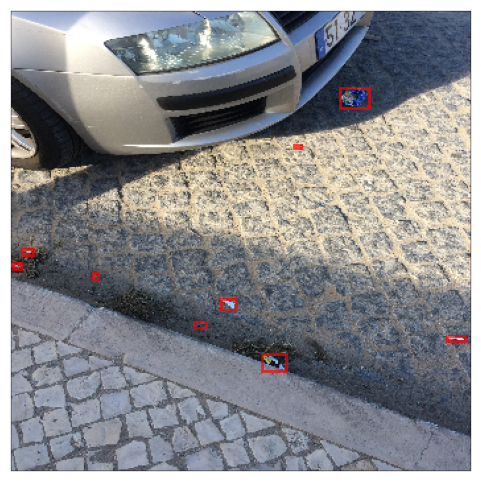

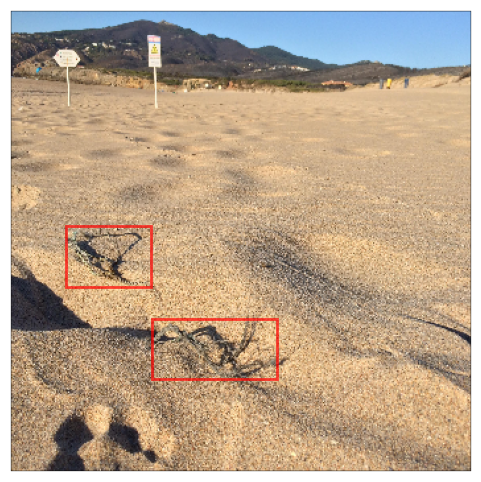

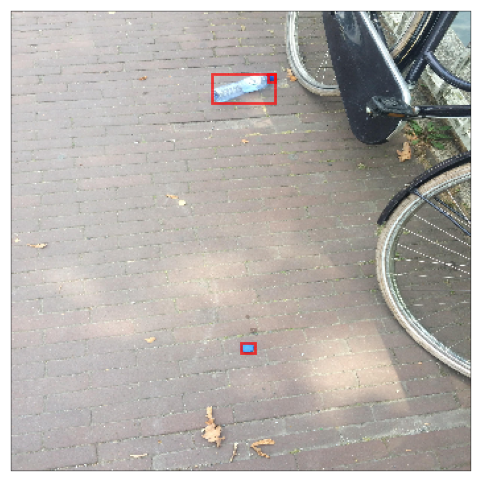

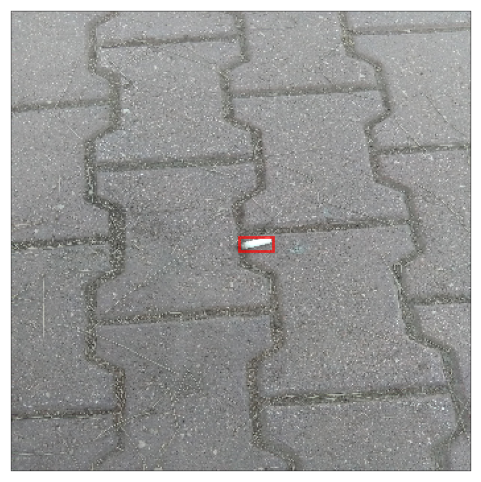

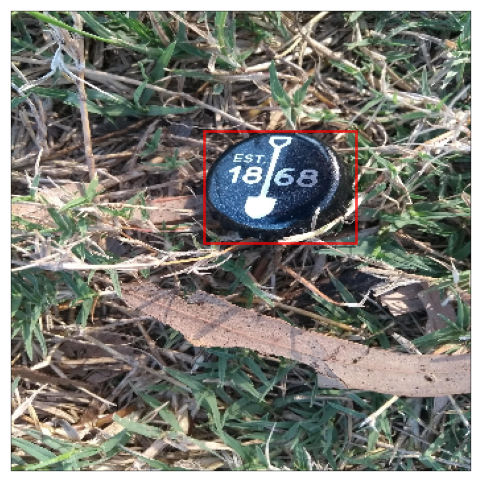

In [5]:
for img_idx in [161, 100, 200, 300, 500]:
        
    image, bboxes, labels = trainset.__getitem__(img_idx)
    
    fig,ax = plt.subplots(1)
    
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    
    # Show annotations
    for ann in bboxes:
        [x, y, x1, y1] = ann
        rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='red',
                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)
    #plt.savefig(f'imgs/output_{img_idx}.png')
    plt.show()

In [6]:
image, bboxes, labels = trainset[161]
bboxes = [list(ele) for ele in bboxes]
bboxes = torch.FloatTensor(bboxes)
order = bboxes.argsort()
print(bboxes[:, 0])
print(bboxes)
print(order[-1])
print(len(bboxes))

tensor([249.1694, 330.5713, 214.5665,   8.5089,  62.3987, 138.6953, 159.6840,
        190.7415,   1.9854])
tensor([[249.1694,  58.4044, 271.1507,  73.7515],
        [330.5713, 246.1936, 344.0438, 250.5633],
        [214.5665, 101.6748, 220.2391, 104.2326],
        [  8.5089, 180.5420,  17.1596, 184.8051],
        [ 62.3987, 198.7668,  65.8023, 203.8825],
        [138.6953, 235.5359, 147.9133, 240.3319],
        [159.6840, 218.5901, 170.4619, 226.4769],
        [190.7415, 260.0487, 208.6102, 273.2643],
        [  1.9854, 191.4129,   7.6580, 195.9957]])
tensor([0, 2, 1, 3])
9


In [7]:
rand_vals = (torch.rand(1,4)-0.5)*20
print(rand_vals)
print(f"Before: {bboxes[0]}, after {bboxes[0]+rand_vals}")
bboxes = torch.cat((bboxes,bboxes[0]+rand_vals),0)
NonMaxSuppress(bboxes, thresh_iou = 0.5)

tensor([[-7.8499, -9.2907,  3.2230, -9.1404]])
Before: tensor([249.1694,  58.4044, 271.1507,  73.7515]), after tensor([[241.3195,  49.1137, 274.3737,  64.6111]])


[tensor([241.3195,  49.1137, 274.3737,  64.6111]),
 tensor([  1.9854, 191.4129,   7.6580, 195.9957]),
 tensor([190.7415, 260.0487, 208.6102, 273.2643]),
 tensor([159.6840, 218.5901, 170.4619, 226.4769]),
 tensor([138.6953, 235.5359, 147.9133, 240.3319]),
 tensor([ 62.3987, 198.7668,  65.8023, 203.8825]),
 tensor([  8.5089, 180.5420,  17.1596, 184.8051]),
 tensor([214.5665, 101.6748, 220.2391, 104.2326]),
 tensor([330.5713, 246.1936, 344.0438, 250.5633]),
 tensor([249.1694,  58.4044, 271.1507,  73.7515])]

In [8]:
IoU(bboxes[0], bboxes[0]+rand_vals)
# 0.0274

RuntimeError: Boolean value of Tensor with more than one value is ambiguous